# Libraries

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import Callback
import numpy as np


from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import time

import pandas as pd
from sklearn.metrics import r2_score, root_mean_squared_error

2024-12-07 11:46:05.942377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733571965.966183   58918 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733571965.973254   58918 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 11:46:06.007194: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Plot of the variables: High, Low, Close

/tmp/ipykernel_58918/2425069474.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill').fillna(method='ffill')


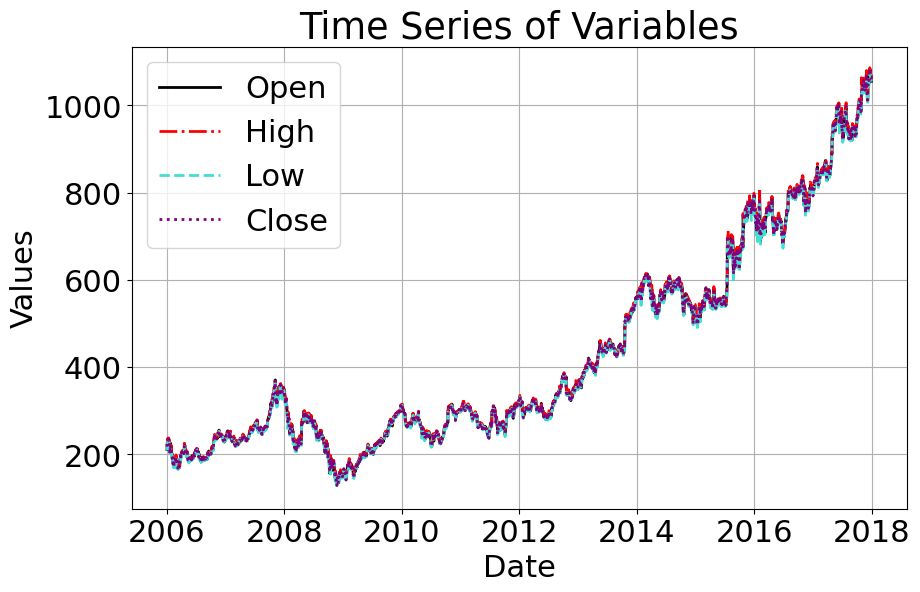

In [9]:
data = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv', parse_dates=['Date'])

data = data.drop("Name", axis=1)
data.set_index('Date', inplace=True)


# Ensure data has business day frequency
data = data.asfreq('b')

# Fill missing values
data = data.fillna(method='bfill').fillna(method='ffill')



#Normalize
train_ratio = 0.8
val_ratio = 0.1
train_end_idx = int(data.shape[0] * train_ratio)
val_end_idx = int(data.shape[0] * (train_ratio + val_ratio))

#scaler = StandardScaler()
#data.iloc[:train_end_idx] = scaler.fit_transform(data.iloc[:train_end_idx])
#data.iloc[train_end_idx:] = scaler.transform(data.iloc[train_end_idx:])




Open=data['Open']
High=data['High']
Low=data['Low']
Close=data['Close']
Volume=data['Volume']
plt.figure(figsize=(10, 6))
plt.plot(data.index, Open, label='Open', linewidth=2, linestyle='-', color='black' )
plt.plot(data.index, High, label='High', linewidth=2, linestyle='-.', color='red' )
plt.plot(data.index, Low, label='Low', linewidth=2, linestyle='--', color='turquoise' )
plt.plot(data.index, Close, label='Close', linewidth=2,linestyle=':', color='purple' )
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series of Variables')
plt.legend()
plt.grid(True)
plt.show()




Plot mean and SD envelopes to see better

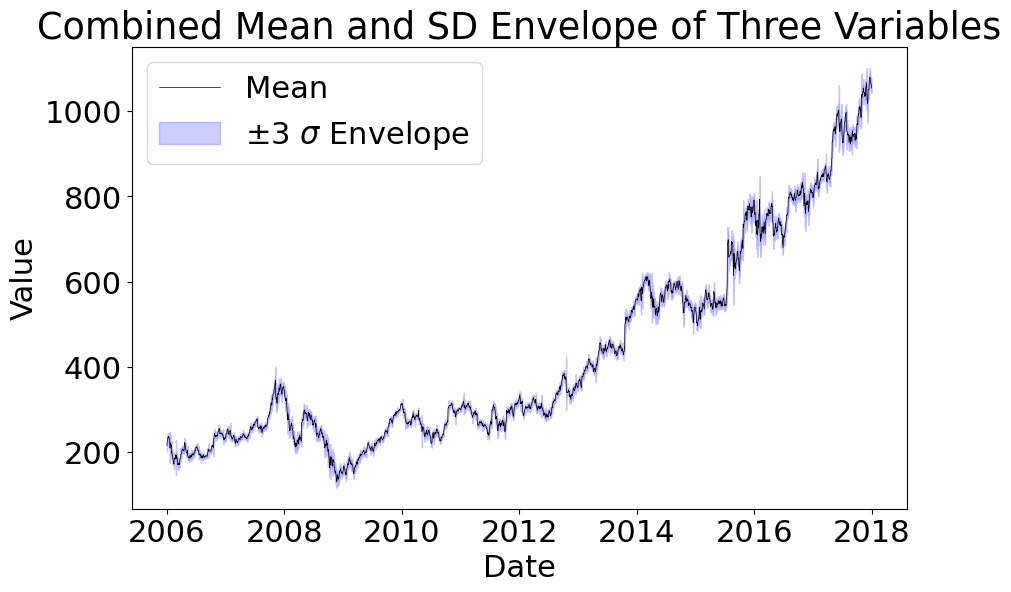

In [10]:
mean_all = data.iloc[:, [0,1, 2, 3]].mean(axis=1)
std_dev_all = data.iloc[:, [0,1, 2, 3]].std(axis=1)
plt.figure(figsize=(10, 6))
plt.plot(data.index, mean_all, label='Mean', color='black', linewidth=0.5)
plt.fill_between(
    data.index,
    mean_all - 3*std_dev_all,
    mean_all + 3*std_dev_all,
    color='blue',
    alpha=0.2,  # Adjust transparency
    label='±3 $\sigma$ Envelope'
)

# Labeling the plot
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Combined Mean and SD Envelope of Three Variables')
plt.legend()
plt.show()


Plot of the variable Volume

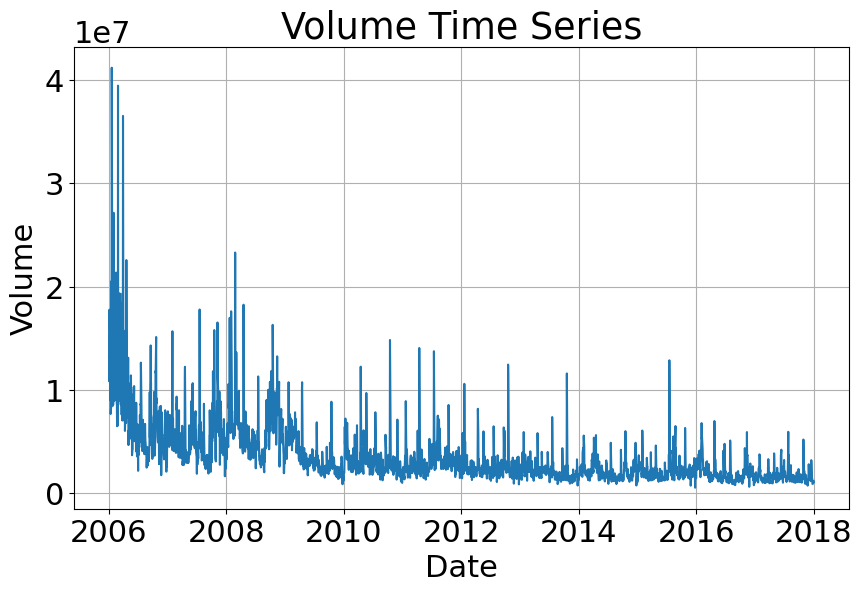

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, Volume, label="Volume")
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Volume Time Series')
plt.grid(True)
plt.savefig("Volume Time Series.png")
plt.show()

Seasonal Trent decomposition using LOESS (STL)

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set_style("darkgrid")


Seasonal Trend Decomposition


/tmp/ipykernel_58918/1046671661.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[cs] = data[cs].fillna(method='ffill')


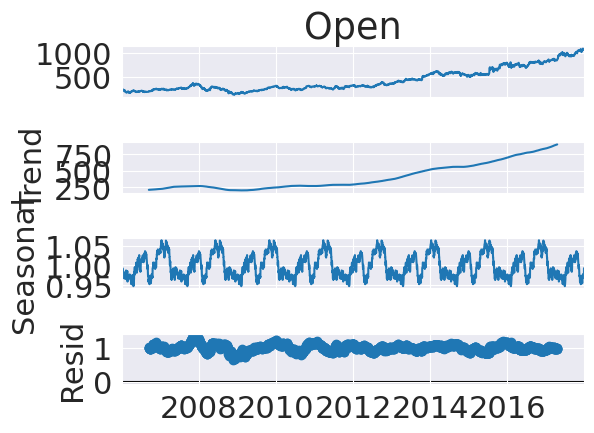

/tmp/ipykernel_58918/1046671661.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[cs] = data[cs].fillna(method='ffill')


<Figure size 640x480 with 0 Axes>

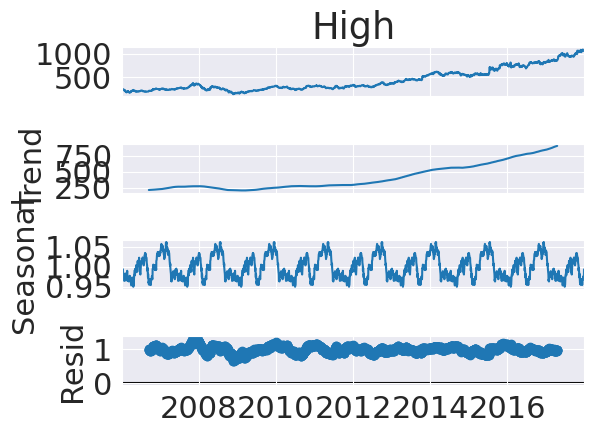

/tmp/ipykernel_58918/1046671661.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[cs] = data[cs].fillna(method='ffill')


<Figure size 640x480 with 0 Axes>

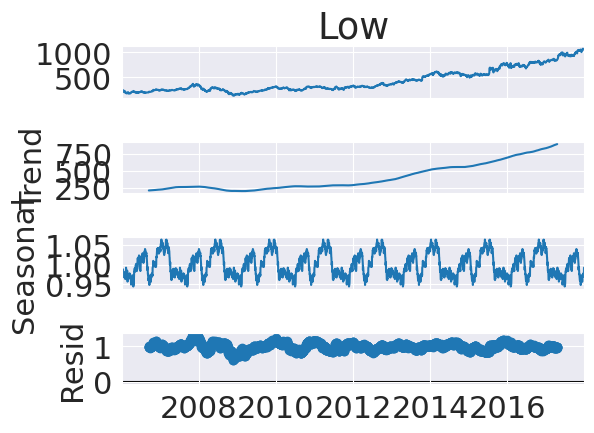

/tmp/ipykernel_58918/1046671661.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[cs] = data[cs].fillna(method='ffill')


<Figure size 640x480 with 0 Axes>

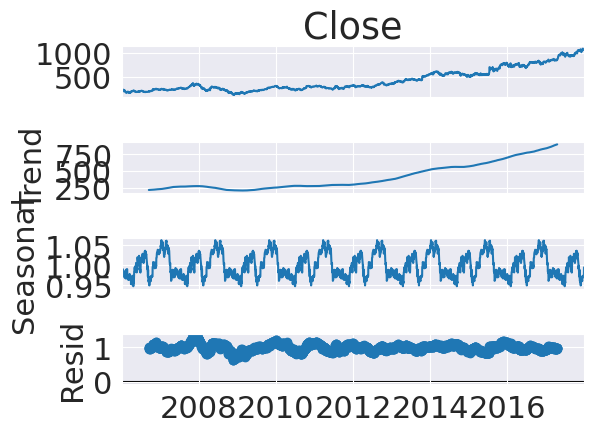

/tmp/ipykernel_58918/1046671661.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[cs] = data[cs].fillna(method='ffill')


<Figure size 640x480 with 0 Axes>

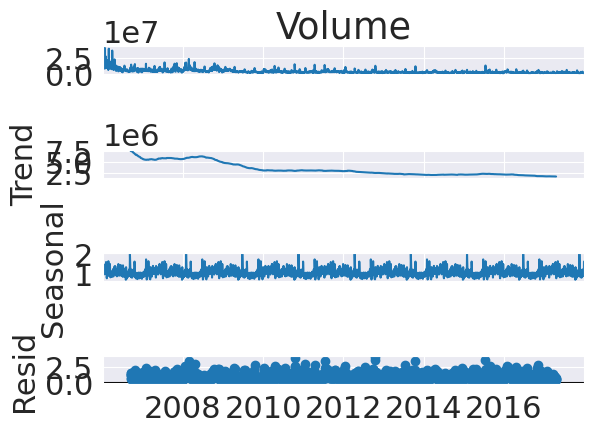

<Figure size 640x480 with 0 Axes>

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

cases=["Open","High","Low","Close", "Volume"]
results={}
for cs in cases:
    data[cs] = data[cs].fillna(method='ffill')
    data[cs].index = pd.to_datetime(data.index)
    data[cs] = data[cs].asfreq('B')

    # daily seasonality
    result = seasonal_decompose(data[cs], model='multiplicative', period=365)
    results[cs]=result
    result.plot()
    plt.show()
    plt.savefig("TSDec_"+cs+".png")


Volume traded per price graph

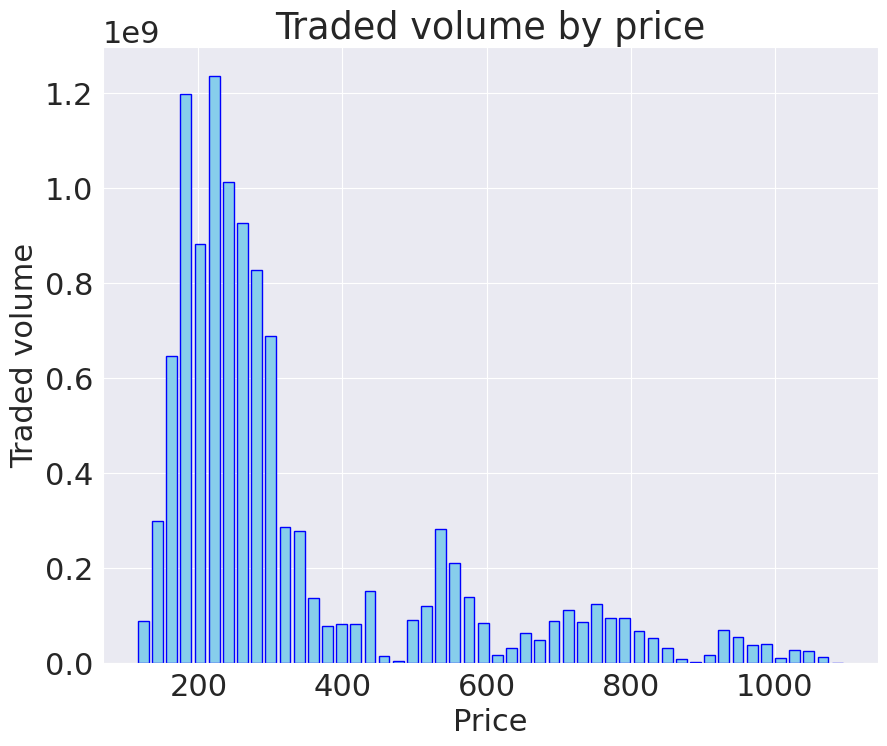

In [14]:
import numpy as np

num_bins = 50 # Number of bins

# Define price bins based on high and low price
price_min = data['Low'].min()
price_max = data['High'].max()
bins = np.linspace(price_min, price_max, num_bins)

# Calculate the midpoints of the bins for plotting

# Calculate the volume in each price bin
volume_by_price = np.zeros(len(bins))

for i in range(len(bins)-1):
    mask = (Close >= bins[i]) & (Close < bins[i + 1])
    volume_by_price[i] = Volume[mask].sum()

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Create a horizontal bar chart for volume by price
ax.bar(bins, volume_by_price, align='center', color='skyblue', edgecolor='blue', width=15)
ax.set_xlabel('Price')
ax.set_ylabel('Traded volume')
ax.set_title('Traded volume by price')
plt.savefig("Traded volume by price.png")
plt.show()

Autocorrelation analysis

            0        1        2        3           4
0      211.47   218.05   209.32   217.83  13137450.0
1      222.17   224.70   220.09   222.84  15292353.0
2      223.22   226.00   220.97   225.85  10815661.0
3      228.66   235.49   226.85   233.06  17759521.0
4      233.44   236.94   230.70   233.68  12795837.0
...       ...      ...      ...      ...         ...
3124  1068.64  1068.86  1058.64  1065.85    918767.0
3125  1068.64  1068.86  1058.64  1065.85    918767.0
3126  1066.60  1068.27  1058.38  1060.20   1116203.0
3127  1062.25  1064.84  1053.38  1055.95    994249.0
3128  1055.49  1058.05  1052.70  1053.40   1180340.0

[3129 rows x 5 columns]
          0         1         2         3         4
0  1.000000  0.999894  0.999843  0.999745 -0.443058
1  0.999894  1.000000  0.999829  0.999868 -0.440613
2  0.999843  0.999829  1.000000  0.999897 -0.447647
3  0.999745  0.999868  0.999897  1.000000 -0.444480
4 -0.443058 -0.440613 -0.447647 -0.444480  1.000000


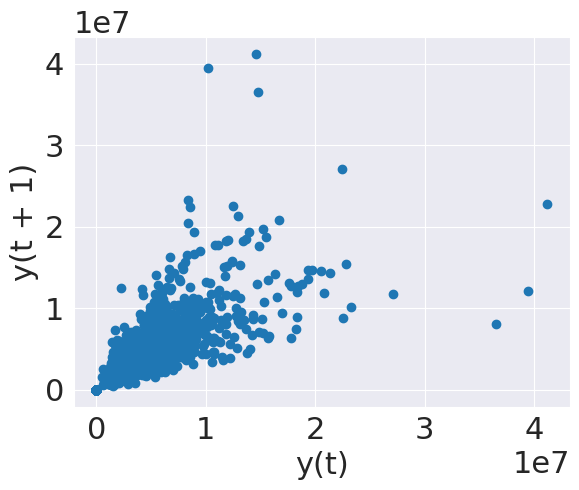

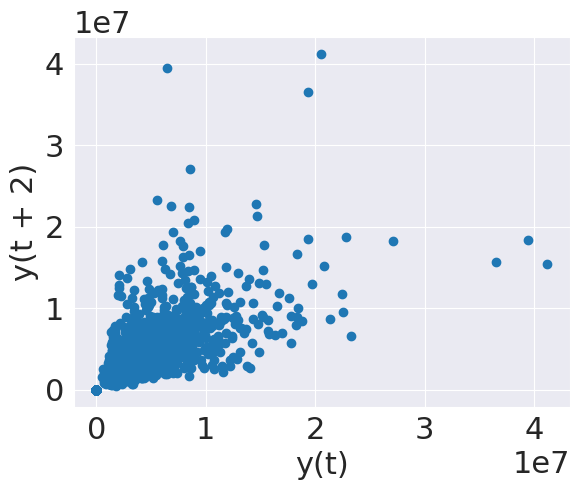

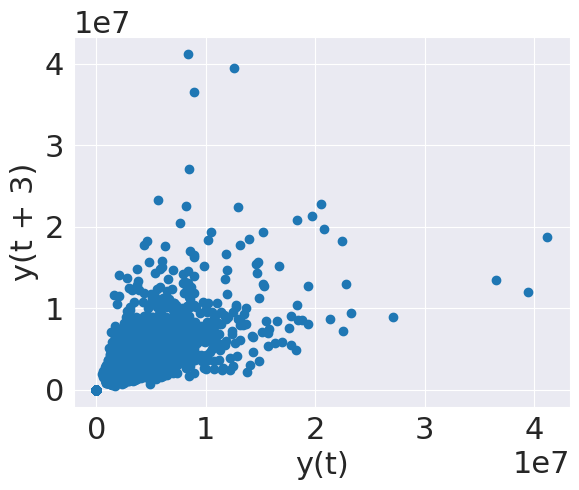

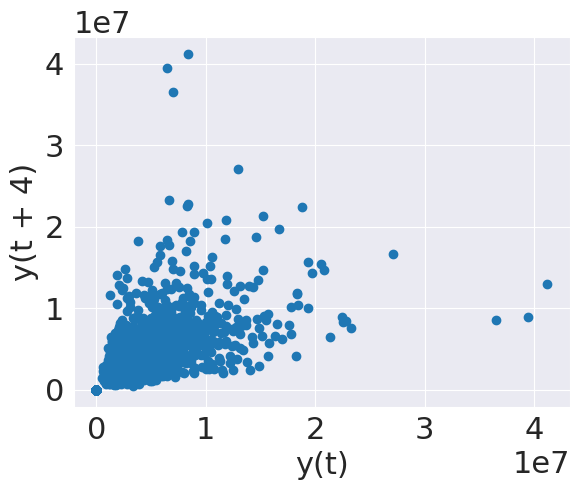

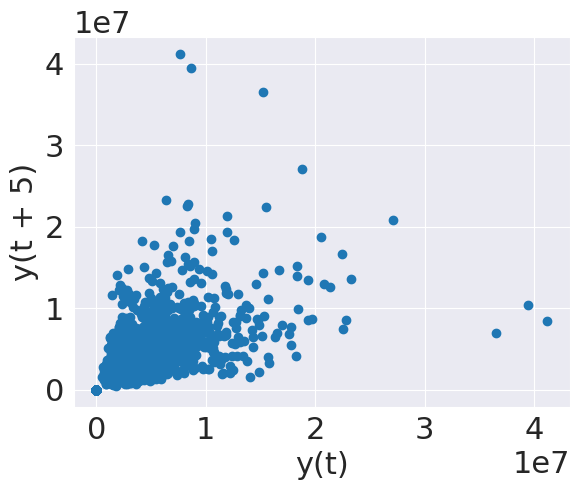

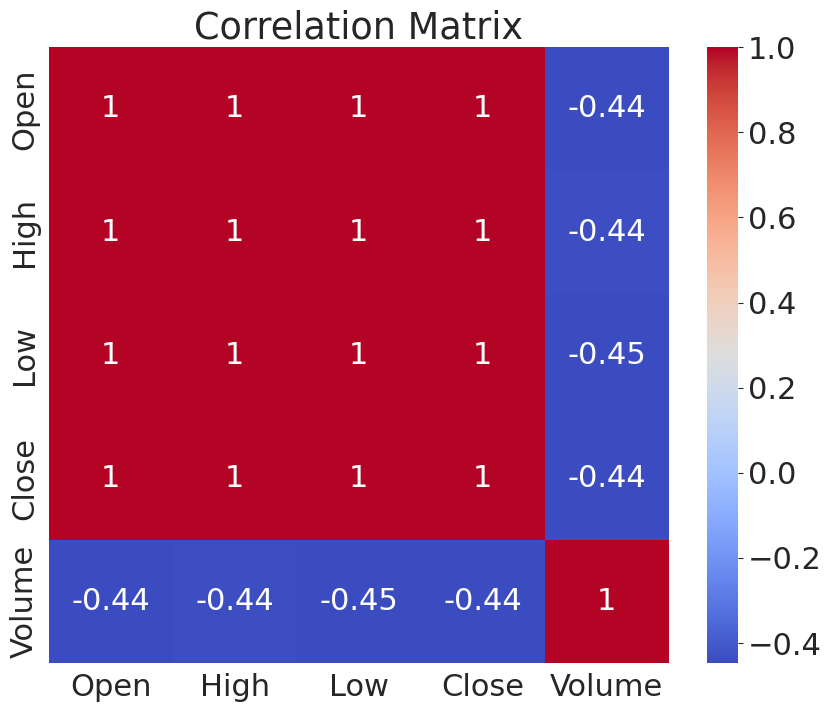

<Figure size 640x480 with 0 Axes>

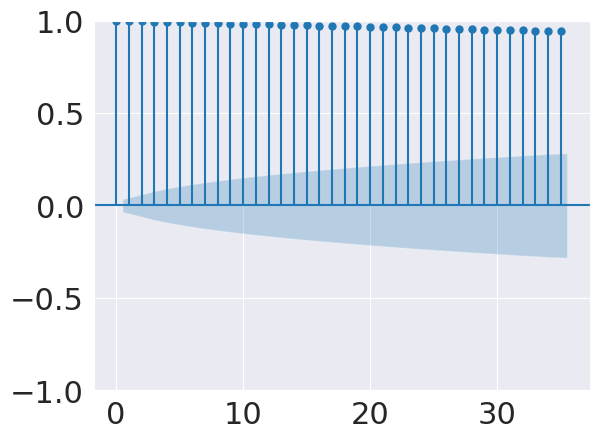

<Figure size 640x480 with 0 Axes>

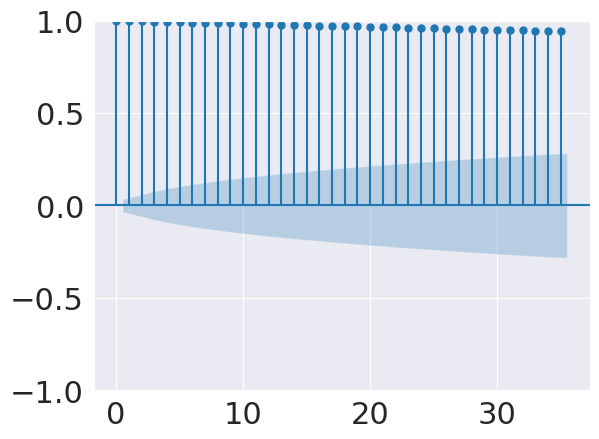

<Figure size 640x480 with 0 Axes>

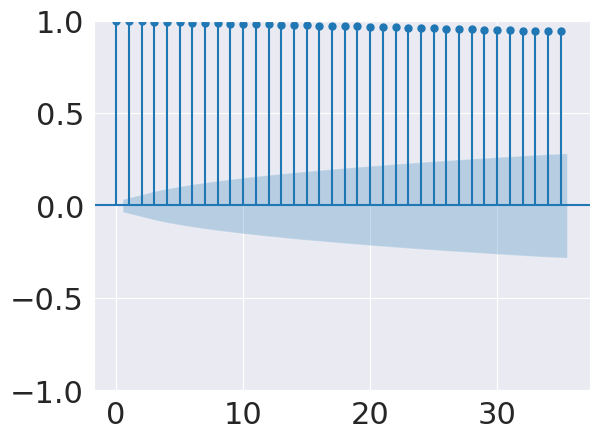

<Figure size 640x480 with 0 Axes>

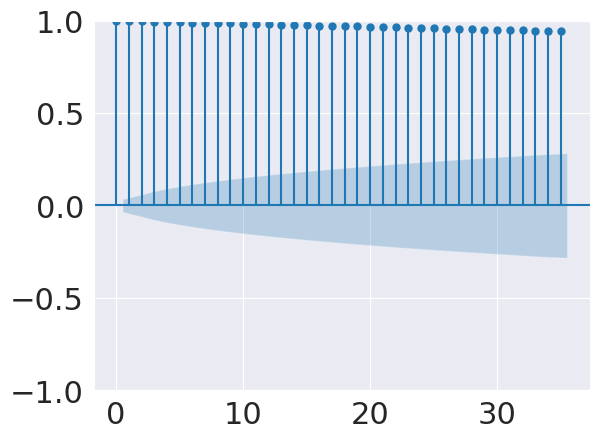

<Figure size 640x480 with 0 Axes>

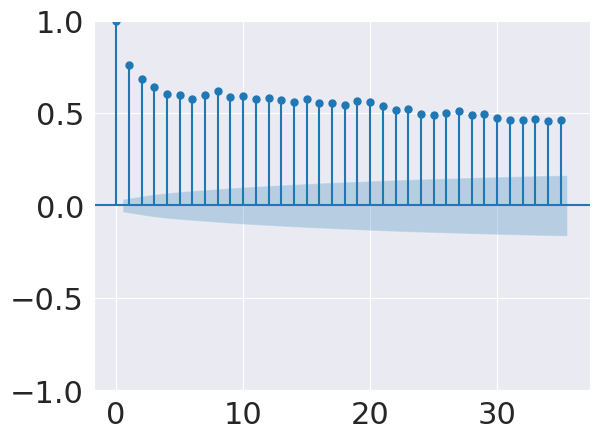

In [15]:
# lagplot
for i in range(5):
    plt.figure()
    pd.plotting.lag_plot(data, lag=i+1)
    #plt.title("Lag plot of variable '" + data.columns[i]  + "'")
    plt.savefig("Lag_plot_" + str(i) + ".png")

# extracting only the temperature values
values = pd.DataFrame(data.values)
print(values)

# Create correlation matrix
correlation_matrix = values.corr()

# Print the correlation matrix
print(correlation_matrix)

# Optionally, plot the correlation matrix for better visualization
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", xticklabels=data.columns, yticklabels=data.columns)
plt.title("Correlation Matrix")
plt.show()

from statsmodels.graphics.tsaplots import plot_acf

for i in range(5):
    plt.figure()
    plot_acf(data.iloc[:, i])
    #plt.title("Autocorrelation of variable '" + data.columns[i]  + "'")
    plt.title("")
    plt.savefig("auc_" + str(i) + ".png")



# $\mathbb{Autoregressive \quad part}$

In [16]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

Modified baseline

In [22]:
cases=["Open", "Close", "Low", "High", "Volume"]
rmse_residuals={}
forecast_horizon=[5,10,20,30,50]
for i in range(0,len(forecast_horizon)):
    series=data[cs]  
    T=10
    D=forecast_horizon[i]
    X=[]
    Y=[]
    rmse_residuals[cs]={}
    for t in range(len(series) - T):
        x=series[t:t+T]
        X.append(x)
        y=series[t+T]
        Y.append(y)
    X=np.array(X).reshape(-1, T)
    Y=np.array(Y)
    N=len(X)
    print("X.shape", X.shape, "Y.shape", Y.shape)
    i=Input(shape=(T,))
    x=Dense(1)(i)
    model=Model(i, x)
    model.compile(
        loss='mse',
        optimizer=Adam(learning_rate=0.1)
    )
    r=model.fit(
        X[:-N//2], Y[:-N//2],
        epochs=80,
        validation_data=(X[-N//2:], Y[-N//2:]),
    )

    plt.plot(r.history["loss"], label="Training Loss")
    plt.plot(r.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.savefig(f"Loss_per_iteration_{cs}.png")
    plt.close()

    validation_target = Y[-D:]  
    validation_predictions = []

    last_x = X[-D]


    while len(validation_predictions) < len(validation_target):
        p = model.predict(last_x.reshape(1, -1))[0, 0]  
        validation_predictions.append(p)
        last_x = np.roll(last_x, -1)  
        last_x[-1] = p

    plt.plot(validation_target, label="Forecast Target")
    plt.plot(validation_predictions, label="Forecast Prediction")
    plt.legend()
    plt.savefig(f"forecast_target_vs_prediction_{cs}.png")
    plt.close()

    rmse_residuals[cs]["RMSE"] = np.sqrt(np.mean((validation_target - validation_predictions) ** 2))
    rmse_residuals[cs]["mean_residuals"] = np.mean(validation_target - validation_predictions)

print("RMSE Residuals:", rmse_residuals)

X.shape (3009, 10) Y.shape (3009,)
Epoch 1/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5868.9595 - val_loss: 611.9772
Epoch 2/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 175.5028 - val_loss: 586.1717
Epoch 3/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170.0908 - val_loss: 1278.9443
Epoch 4/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 183.2131 - val_loss: 386.3843
Epoch 5/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134.9143 - val_loss: 338.4351
Epoch 6/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 103.4685 - val_loss: 298.4197
Epoch 7/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 155.8210 - val_loss: 821.5214
Epoch 8/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 159.9668 - val_loss: 743.2523
Epoch 9/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 104.5249 - val_loss: 504.5537
Epoch 10/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 260.2551 - val_loss: 919.6068
Epoch 11/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 185.2822 - val_loss: 53

In [31]:
data = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv', parse_dates=['Date'])
data = data.drop("Name", axis=1)
data.set_index('Date', inplace=True)
# Ensure data has business day frequency
data = data.asfreq('b')
# Fill missing values
data = data.fillna(method='bfill').fillna(method='ffill')
dates = data.index

rmse_residuals={}
forecast_horizon=[5,10,20,30,50]
series=data["Close"]  
for j in range(0,len(forecast_horizon)):
    T=100
    D=forecast_horizon[j]
    X=[]
    Y=[]
    rmse_residuals[j]={}
    for t in range(len(series) - T):
        x=series[t:t+T]
        X.append(x)
        y=series[t+T]
        Y.append(y)
    X=np.array(X).reshape(-1, T)
    Y=np.array(Y)
    N=len(X)
    print("X.shape", X.shape, "Y.shape", Y.shape)
    i=Input(shape=(T,))
    x=Dense(1)(i)
    model=Model(i, x)
    model.compile(
        loss='mse',
        optimizer=Adam(learning_rate=0.1)
    )
    r=model.fit(
        X[:-N//2], Y[:-N//2],
        epochs=80,
        validation_data=(X[-N//2:], Y[-N//2:]),
    )

    plt.plot(r.history["loss"], label="Training Loss")
    plt.plot(r.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.savefig(f"Loss_per_iteration_{j}.png")
    plt.close()

    validation_target = Y[T:T+D]  
    validation_predictions = []

    last_x = X[T]


    while len(validation_predictions) < len(validation_target):
        p = model.predict(last_x.reshape(1, -1))[0, 0]  
        validation_predictions.append(p)
        last_x = np.roll(last_x, -1)  
        last_x[-1] = p

    full_target = np.concatenate([Y[:T], validation_target])
    full_predictions = np.concatenate([Y[:T], validation_predictions])
    full_dates = dates[:T + D]

    # Plot forecast vs. target with dates on the x-axis
    plt.figure(figsize=(12, 6))
    plt.plot(full_dates, full_target, label="Actual Target", color="blue")
    plt.plot(full_dates[-D:], validation_predictions, label="Forecast Prediction", color="orange")
    plt.axvline(x=full_dates[100], color="red", linestyle="--", label="Forecast Start")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.title(f"Forecast vs. Actual for Horizon = {D}")
    plt.savefig(f"forecast_target_vs_prediction_{j}.png")
    plt.close()

    rmse_residuals[j]["RMSE"] = np.sqrt(np.mean((validation_target - validation_predictions) ** 2))
    rmse_residuals[j]["mean_residuals"] = np.mean(validation_target - validation_predictions)

print("RMSE Residuals:", rmse_residuals)

/tmp/ipykernel_58918/3938127365.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_58918/3938127365.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y=series[t+T]


X.shape (3029, 100) Y.shape (3029,)
Epoch 1/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1063588.2500 - val_loss: 222477.0156
Epoch 2/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9575.2393 - val_loss: 2680.0510
Epoch 3/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 665.9352 - val_loss: 824.5535
Epoch 4/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 368.4852 - val_loss: 657.3475
Epoch 5/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 295.9963 - val_loss: 588.5603
Epoch 6/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 181.1596 - val_loss: 802.9496
Epoch 7/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 181.4453 - val_loss: 504.2523
Epoch 8/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 198.6279 - val_loss: 591.3173
Epoch 9/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 140.0164 - val_loss: 392.4415
Epoch 10/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 139.5615 - val_loss: 670.2379
Epoch 11/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 142.5681 - val_

/tmp/ipykernel_58918/3938127365.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y=series[t+T]


X.shape (3029, 100) Y.shape (3029,)
Epoch 1/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 989654.2500 - val_loss: 113617.0859
Epoch 2/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7745.3936 - val_loss: 5622.7715
Epoch 3/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 787.8309 - val_loss: 703.0435
Epoch 4/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 314.3652 - val_loss: 1075.9501
Epoch 5/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 268.4293 - val_loss: 1575.9775
Epoch 6/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 292.9112 - val_loss: 444.2210
Epoch 7/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 213.9377 - val_loss: 850.8206
Epoch 8/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 226.3527 - val_loss: 2998.1943
Epoch 9/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 284.0450 - val_loss: 823.4056
Epoch 10/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 180.2659 - val_loss: 410.1758
Epoch 11/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 170.6452 - va

/tmp/ipykernel_58918/3938127365.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y=series[t+T]


X.shape (3029, 100) Y.shape (3029,)
Epoch 1/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1170814.1250 - val_loss: 123341.2344
Epoch 2/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9302.9404 - val_loss: 1143.8065
Epoch 3/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 514.1325 - val_loss: 1591.2065
Epoch 4/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 387.7918 - val_loss: 994.2735
Epoch 5/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 344.0816 - val_loss: 774.5641
Epoch 6/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 291.2083 - val_loss: 724.3617
Epoch 7/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 272.4399 - val_loss: 1165.3619
Epoch 8/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 253.8750 - val_loss: 1452.3597
Epoch 9/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 296.8389 - val_loss: 1460.2233
Epoch 10/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 280.6460 - val_loss: 513.8979
Epoch 11/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 221.6098 - 

/tmp/ipykernel_58918/3938127365.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y=series[t+T]


X.shape (3029, 100) Y.shape (3029,)
Epoch 1/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1133402.6250 - val_loss: 136260.0000
Epoch 2/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8843.8057 - val_loss: 990.3778
Epoch 3/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 577.9965 - val_loss: 635.7071
Epoch 4/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 300.4459 - val_loss: 525.9194
Epoch 5/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 215.8165 - val_loss: 1012.6845
Epoch 6/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 257.2337 - val_loss: 1514.6692
Epoch 7/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 231.5956 - val_loss: 480.5640
Epoch 8/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 182.8227 - val_loss: 442.7456
Epoch 9/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 167.8878 - val_loss: 722.0234
Epoch 10/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 172.7516 - val_loss: 1164.4878
Epoch 11/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 172.4997 - va

/tmp/ipykernel_58918/3938127365.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y=series[t+T]


X.shape (3029, 100) Y.shape (3029,)
Epoch 1/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 752301.2500 - val_loss: 92213.2891
Epoch 2/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7050.5879 - val_loss: 2463.2310
Epoch 3/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 974.4793 - val_loss: 2884.7234
Epoch 4/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 512.4149 - val_loss: 3617.8508
Epoch 5/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 374.3578 - val_loss: 520.1243
Epoch 6/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 228.4426 - val_loss: 605.8925
Epoch 7/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 247.9640 - val_loss: 898.6506
Epoch 8/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 301.0145 - val_loss: 419.7802
Epoch 9/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 183.9837 - val_loss: 382.6148
Epoch 10/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 186.2036 - val_loss: 540.9982
Epoch 11/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 171.5609 - val_

In [32]:
df = pd.DataFrame.from_dict(rmse_residuals, orient='index')

# Display the DataFrame
print(df)

         RMSE  mean_residuals
0   41.656774      -39.042735
1  461.353638      421.674843
2  156.253683     -137.332938
3  130.248393      112.167371
4  394.893766     -324.695822


# **LSTM Part**

Lagged Variables


In [ ]:
# Function to create lagged variables for time series
def create_lagged_data(dataset, num_lags=1, forecast=1, drop_na=True):
    n_features = dataset.shape[1]
    columns, names = [], []

    for lag in range(num_lags, 0, -1):
        columns.append(dataset.shift(lag))
        names += [f'{dataset.columns[col]}(t-{lag})' for col in range(n_features)]

    for step in range(0, forecast):
        columns.append(dataset.shift(-step))
        names += [f'{dataset.columns[col]}(t)' for col in range(n_features)]

    result = pd.concat(columns, axis=1)
    result.columns = names
    if drop_na:
        result.dropna(inplace=True)
    return result

# Create lagged variables
num_lag_steps = 50
processed_data = create_lagged_data(data, num_lags=num_lag_steps, forecast=1)

# Drop unnecessary columns
processed_data.drop(['High(t)', 'Low(t)', 'Volume(t)', f'Open(t-{num_lag_steps})'], axis=1, inplace=True)


In [ ]:
# Split data into train, validation, and test sets
train_features = processed_data.iloc[:train_end_idx, :-1].values
train_labels = processed_data.iloc[:train_end_idx, -1].values
val_features = processed_data.iloc[train_end_idx:val_end_idx, :-1].values
val_labels = processed_data.iloc[train_end_idx:val_end_idx, -1].values
test_features = processed_data.iloc[val_end_idx:, :-1].values
test_labels = processed_data.iloc[val_end_idx:, -1].values

# Reshape for LSTM
num_features = data.shape[1]
train_features = train_features.reshape((train_features.shape[0], num_lag_steps, num_features))
val_features = val_features.reshape((val_features.shape[0], num_lag_steps, num_features))
test_features = test_features.reshape((test_features.shape[0], num_lag_steps, num_features))


Define and Train the LSTM Model

In [ ]:
# Define LSTM model
hidden_units = 500
batch_size = 32
n_epochs = 100
learning_rate = 0.0005

optimizer = Adam(learning_rate=learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential()
model.add(LSTM(hidden_units, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer=optimizer)

# Train the model
start_time = time.time()
history = model.fit(
    train_features, train_labels, epochs=n_epochs, batch_size=batch_size,
    validation_data=(val_features, val_labels), verbose=2, shuffle=False,
    callbacks=[early_stopping]
)
end_time = time.time()
print("Total training time:", end_time - start_time)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()


/home/irene/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
79/79 - 21s - 266ms/step - loss: 130609.6797 - val_loss: 574146.5625
Epoch 2/100
79/79 - 19s - 245ms/step - loss: 127756.6094 - val_loss: 568099.6875
Epoch 3/100
79/79 - 19s - 245ms/step - loss: 125170.8594 - val_loss: 562281.2500
Epoch 4/100


KeyboardInterrupt: 

Make Predictions and Evaluate

In [ ]:
# Make predictions
pred_train = model.predict(train_features).flatten()
pred_val = model.predict(val_features).flatten()
pred_test = model.predict(test_features).flatten()

# Rescale predictions and actual values
mean_close = scaler.mean_[scaler.feature_names_in_ == 'Close'][0]
std_close = np.sqrt(scaler.var_[scaler.feature_names_in_ == 'Close'][0])

pred_all = np.concatenate([pred_train, pred_val, pred_test]) * std_close + mean_close
actual_all = np.concatenate([train_labels, val_labels, test_labels]) * std_close + mean_close

# Plot predictions vs actual values
plt.plot(data.iloc[num_lag_steps:].index, pred_all, label='Predicted', color='blue')
plt.plot(data.iloc[num_lag_steps:].index, actual_all, label='Actual', color='orange')
plt.axvline(x=data.iloc[train_end_idx].name, color='yellow', label='Validation Split')
plt.axvline(x=data.iloc[val_end_idx].name, color='red', label='Test Split')
plt.legend()
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel("Date")
plt.ylabel("Closing Stock Price")
plt.grid(True)
plt.show()

# Calculate evaluation metrics
train_rmse = np.sqrt(mean_squared_error(actual_all[:train_end_idx], pred_all[:train_end_idx]))
val_rmse = np.sqrt(mean_squared_error(actual_all[train_end_idx:val_end_idx], pred_all[train_end_idx:val_end_idx]))
test_rmse = np.sqrt(mean_squared_error(actual_all[val_end_idx:], pred_all[val_end_idx:]))

print(f"Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}, Test RMSE: {test_rmse}")


predictions vs actual values for the test set



In [ ]:
# Predictions vs actual values for the test set
plt.figure(figsize=(12, 6))
plt.plot(data.iloc[num_lag_steps + val_end_idx:].index, pred_all[val_end_idx:], label='Predicted', color='blue')
plt.plot(data.iloc[num_lag_steps + val_end_idx:].index, actual_all[val_end_idx:], label='Real', color='orange')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing Stock Price")
plt.title("LSTM Results for Test Set")
plt.grid(True)
plt.show()


# RNN Part

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.metrics import mean_squared_error

# Normalize the data (apply MinMaxScaler across all features)
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

# Define sequence length
sequence_length = 100

# Prepare input (X) and output (Y) sequences
X, Y = [], []
for i in range(len(data_normalized) - sequence_length):
    X.append(data_normalized[i:i + sequence_length])  # Input: sequence_length x num_features
    Y.append(data_normalized[i + sequence_length])    # Output: num_features

X = np.array(X)  # Shape: (samples, sequence_length, num_features)
Y = np.array(Y)  # Shape: (samples, num_features)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))
X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = Y[:split_index], Y[split_index:]

Epoch 1/20


2024-11-30 12:31:42.162670: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/irene/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0058
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.2681e-04
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.3812e-04
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.9113e-04
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.4001e-04
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.8638e-04
Epoch 7/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.4600e-04
Epoch 8/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.5749e-04
Epoch 9/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.5153e-04
Epoch 10/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 2.9133e-04
Epoch 11/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 3.0303e-04
Epoch 12/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.2179e-04
Epoch 13/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.5431e-04
Epoch 14/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.4617e-04
Ep

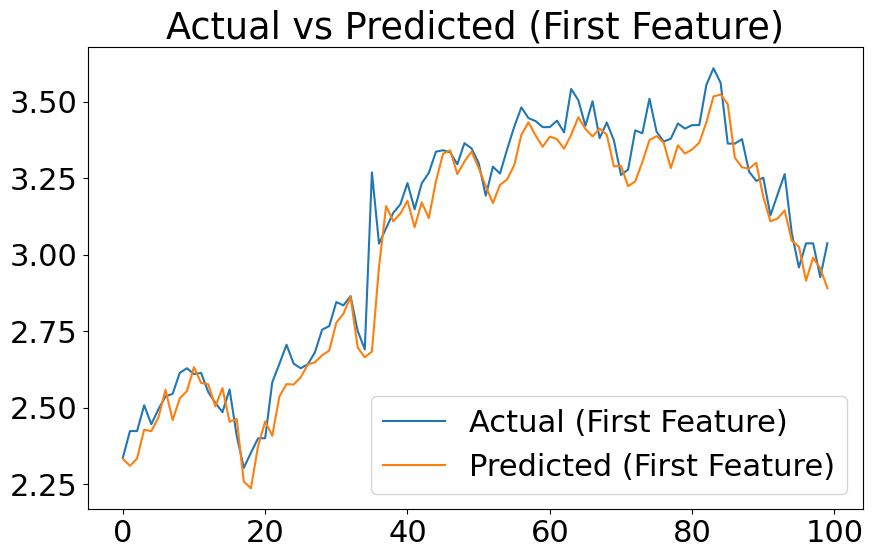

In [ ]:
# Build the LSTM model for multivariate input/output
model = Sequential([
    SimpleRNN(units=80, input_shape=(sequence_length, X.shape[2])),  # Sequence length and features
    Dense(units=Y.shape[1])  # Number of output features
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, epochs=20, batch_size=20, verbose=1)

# Predict on the test set
predictions = model.predict(X_test)

# Inverse scale predictions and actual values for evaluation
predictions_rescaled = scaler.inverse_transform(predictions)
Y_test_rescaled = scaler.inverse_transform(Y_test)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(Y_test_rescaled, predictions_rescaled)
print(f"Mean Squared Error: {mse}")

# Optional: Visualize some predictions vs actuals
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(Y_test_rescaled[:100, 0], label='Actual (First Feature)')
plt.plot(predictions_rescaled[:100, 0], label='Predicted (First Feature)')
plt.legend()
plt.title("Actual vs Predicted (First Feature)")
plt.show()

In [ ]:
# Initialize prediction_X with the last sequence from the dataset
prediction_X = X[0]  # Ensure this is a sequence of shape (sequence_length, num_features)

# Number of steps to forecast
steps = 100

# Store forecasts
forecasts = []

for i in range(steps):
    # Reshape prediction_X to include batch dimension
    prediction_X_batch = prediction_X.reshape((1, prediction_X.shape[0], prediction_X.shape[1]))

    # Predict the next step
    forecast_new = model.predict(prediction_X_batch)

    # Add the prediction to forecasts
    forecasts.append(forecast_new[0])  # Remove batch dimension from prediction

    # Update prediction_X: Remove the first value and append the new prediction
    prediction_X = np.vstack([prediction_X[1:], forecast_new])

# Convert forecasts to a NumPy array for further processing
forecasts = np.array(forecasts)

# Inverse transform the forecasts if needed (to return to original scale)
forecasts_rescaled = scaler.inverse_transform(forecasts)
print("Forecasts (original scale):")
print(forecasts_rescaled)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

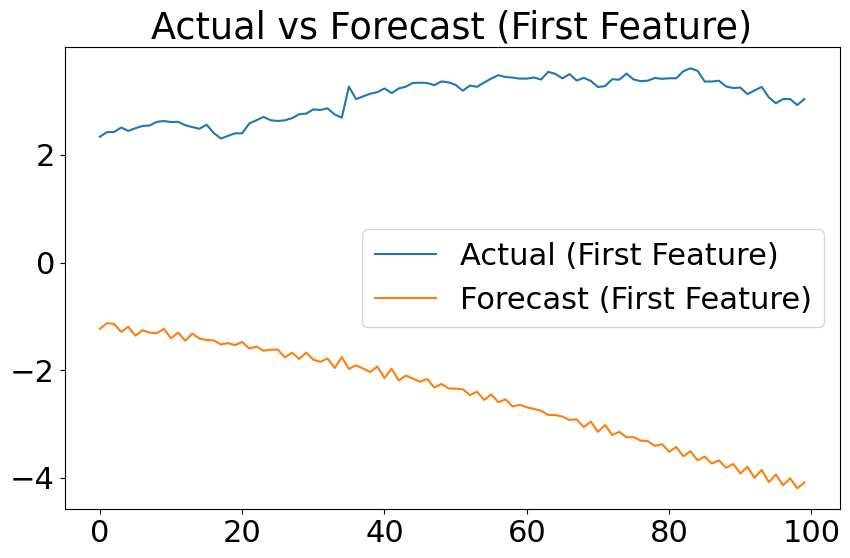

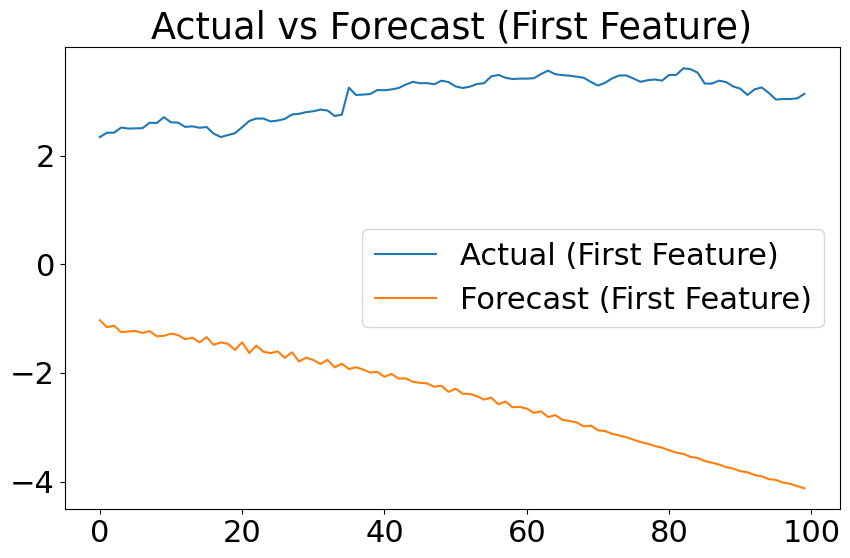

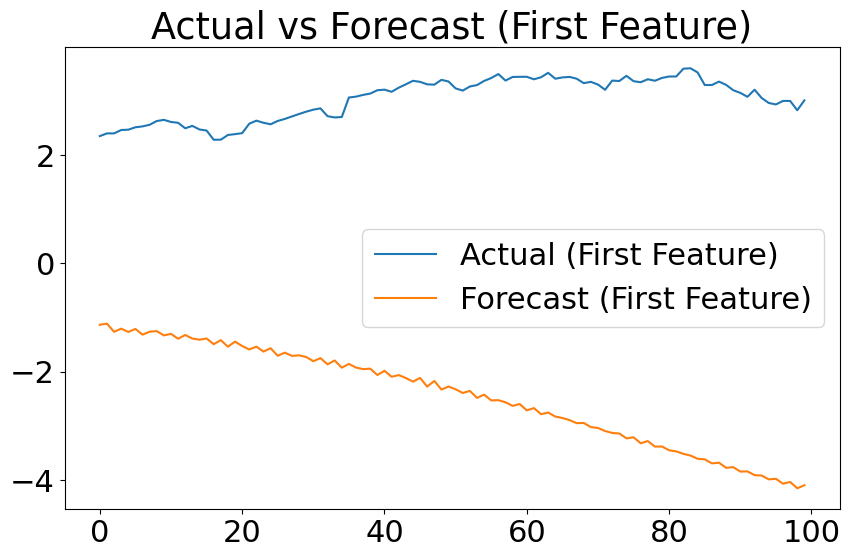

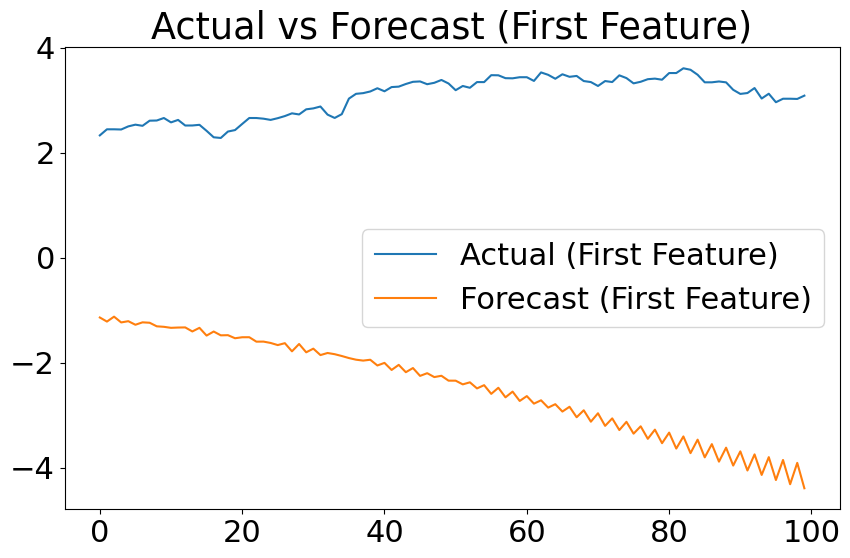

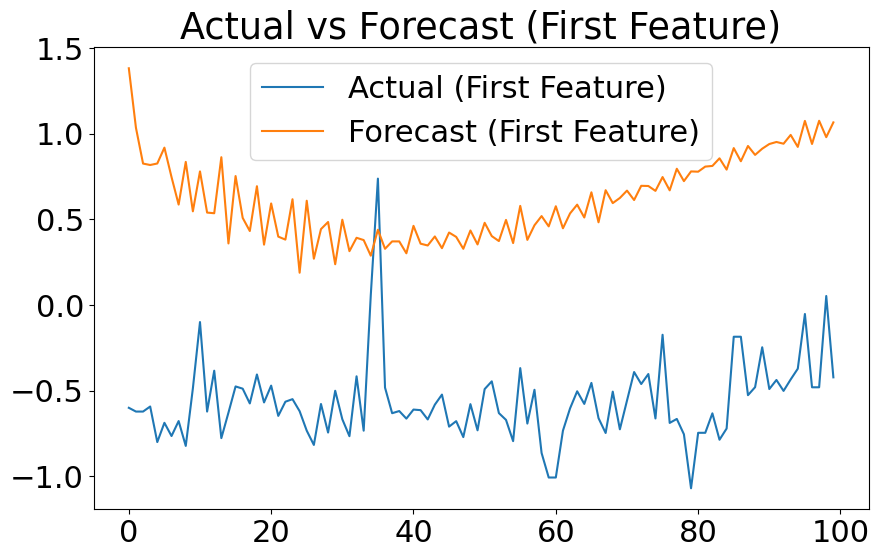

In [ ]:
for i in range(0,5):
    plt.figure(figsize=(10, 6))
    plt.plot(Y_test_rescaled[:100, i], label='Actual (First Feature)')
    plt.plot(forecasts_rescaled[:100,i], label='Forecast (First Feature)')
    plt.legend()
    plt.title("Actual vs Forecast (First Feature)")
    plt.show()